In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm

In [2]:
train_df = pd.read_csv("/kaggle/input/Kannada-MNIST/train.csv")
test_df = pd.read_csv("/kaggle/input/Kannada-MNIST/Dig-MNIST.csv")
submission_set = pd.read_csv("/kaggle/input/Kannada-MNIST/test.csv")

In [3]:
train_image = train_df.drop(columns=["label"])
train_label = train_df["label"]

test_image = test_df.drop(columns=["label"])
test_label = test_df["label"]

prediction_image = submission_set.drop(columns=["id"])

In [4]:
from sklearn.model_selection import train_test_split
train_image, val_image, train_label, val_label = train_test_split(train_image, train_label, test_size=0.3)

In [5]:
train_image.reset_index(drop=True, inplace=True)
train_label.reset_index(drop=True, inplace=True)

val_image.reset_index(drop=True, inplace=True)
val_label.reset_index(drop=True, inplace=True)

test_image.reset_index(drop=True, inplace=True)
test_label.reset_index(drop=True, inplace=True)

prediction_image.reset_index(drop=True, inplace=True)

In [6]:
IMAGE_SIZE = 28

class KannadaDataset(Dataset):
    def __init__(self, images, labels, transforms = None) -> None:
        self.X = images
        self.y = labels
        self.transforms = transforms
    
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X.iloc[i,:]
        data = np.array(data).astype(np.uint8).reshape(IMAGE_SIZE, IMAGE_SIZE, 1)
        if self.transforms:
            data = self.transforms(data)  
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data

In [7]:
train_transforms = transforms.Compose(([
    transforms.ToPILImage(),
    transforms.ToTensor(),
]))

val_transforms = transforms.Compose(([
    transforms.ToPILImage(),
    transforms.ToTensor(),
]))

In [8]:
BATCH_SIZE = 32

train_dataset = KannadaDataset(train_image, train_label, train_transforms)

val_dataset = KannadaDataset(val_image, val_label, val_transforms)

test_dataset = KannadaDataset(test_image, test_label, val_transforms)

submission_dataset = KannadaDataset(prediction_image, None, val_transforms)

train_dataloader = DataLoader(train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True)
val_dataloader = DataLoader(val_dataset,
                            batch_size = BATCH_SIZE,
                            shuffle = False)
test_dataloader = DataLoader(test_dataset,
                             batch_size = BATCH_SIZE,
                             shuffle = False)
prediction_dataloader = DataLoader(submission_dataset,
                                   batch_size = BATCH_SIZE,
                                   shuffle = False)

tensor([5, 3, 3, 0, 2, 6, 1, 4])


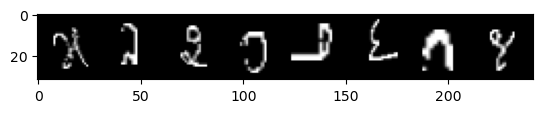

In [9]:
images, labels = next(iter(train_dataloader))
images, labels = images[:8], labels[:8]
plt.imshow(torchvision.utils.make_grid(images)[0,:,:], cmap="gray")
print(labels)

In [10]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

In [11]:
class KannadaCNN(nn.Module):
    def __init__(self, ouputs) -> None:
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()            
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(128*7*7, 4096),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU()
        )
        self.fc3 = nn.Sequential(
            nn.Linear(4096, ouputs)
        )
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [12]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
def trainModel(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               optimizer: torch.optim.Optimizer, 
               loss_fn = torch.nn.Module, 
               device: torch.device = device):
    model.train()
    train_loss, train_acc = 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_score(y.cpu(), y_pred.cpu().argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f}")

In [15]:
def valMmodel(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
    val_loss, val_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            val_loss += loss_fn(y_pred, y)
            val_acc += accuracy_score(y.cpu(), y_pred.cpu().argmax(dim=1))
        val_loss /= len(dataloader)
        val_acc /= len(dataloader)
        print(f"Val loss: {val_loss:.4f} | Val accuracy: {val_acc:.4f}")
        return val_loss

In [16]:
def evalModel(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module,
               device: torch.device = device):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_score(y.cpu(), y_pred.cpu().argmax(dim=1)) 
        loss /= len(dataloader)
        acc /= len(dataloader)       
    return {"model_name": model.__class__.__name__, 
            "model_loss": loss.item(),
            "model_acc": acc}

In [17]:
model = KannadaCNN(len(classes)).to(device)
print(model)

KannadaCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [19]:
torch.manual_seed(0)
EPOCHS = 50
early_stopping = EarlyStopping(patience=5, verbose=False, delta=0.001)
for epoch in tqdm(range(EPOCHS)):
    trainModel(model, train_dataloader, optimizer, loss_fn, device)
    val_loss = valMmodel(model, val_dataloader, loss_fn, device)
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        break

  0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0005 | Train accuracy: 0.5296
Val loss: 0.7115 | Val accuracy: 0.7922
Train loss: 0.0007 | Train accuracy: 0.6162
Val loss: 0.6867 | Val accuracy: 0.7225
Train loss: 0.0011 | Train accuracy: 0.6245
Val loss: 0.6794 | Val accuracy: 0.7827
Train loss: 0.0001 | Train accuracy: 0.8487
Val loss: 0.0938 | Val accuracy: 0.9738
Train loss: 0.0003 | Train accuracy: 0.9241
Val loss: 0.0908 | Val accuracy: 0.9742
Train loss: 0.0001 | Train accuracy: 0.9394
Val loss: 0.0634 | Val accuracy: 0.9847
Train loss: 0.0000 | Train accuracy: 0.9405
Val loss: 0.0564 | Val accuracy: 0.9855
Train loss: 0.0001 | Train accuracy: 0.9477
Val loss: 0.0545 | Val accuracy: 0.9858
Train loss: 0.0000 | Train accuracy: 0.9448
Val loss: 0.0486 | Val accuracy: 0.9860
Train loss: 0.0000 | Train accuracy: 0.9433
Val loss: 0.0548 | Val accuracy: 0.9847
EarlyStopping counter: 1 out of 5
Train loss: 0.0001 | Train accuracy: 0.9479
Val loss: 0.0504 | Val accuracy: 0.9860
EarlyStopping counter: 2 out of 5
Train lo

In [20]:
model_results = evalModel(model, test_dataloader, loss_fn, device)
print(model_results)

{'model_name': 'KannadaCNN', 'model_loss': 0.8797635436058044, 'model_acc': 0.77666015625}


In [21]:
submission = pd.read_csv("/kaggle/input/Kannada-MNIST/sample_submission.csv")
submission.head()

,id,label
0,0,5
1,1,5
2,2,5
3,3,5
4,4,5


In [32]:
preds = torch.LongTensor().to(device)
model.eval()
with torch.inference_mode():
    for X in prediction_dataloader:
        X= X.to(device)
        y_pred = model(X)
        preds = torch.cat((preds, y_pred.argmax(dim=1)), dim=0)
submission["label"] = preds.cpu().numpy()
submission.to_csv("submission.csv", index=False)